In [1]:
suppressPackageStartupMessages({
    library(here) # All paths relative to the git directory
    library(ggplot2)
    library(patchwork)
    library(lubridate)
    library(dplyr)
    library(mgcv)
    library(tidygam)
    theme_set(theme_bw())
})
expit <- function(x) 1 / (1 + exp(-x))


In [2]:
jahn <- read.csv(here("data", "jahn_variants.csv"))
# Cleaning location names. 
jahn[, "locality"] <- strsplit(jahn[, "locality"], split = " - ") |> 
    sapply(function(x) x[2])
jahn[, "date"] <- ymd(jahn[, "date"])


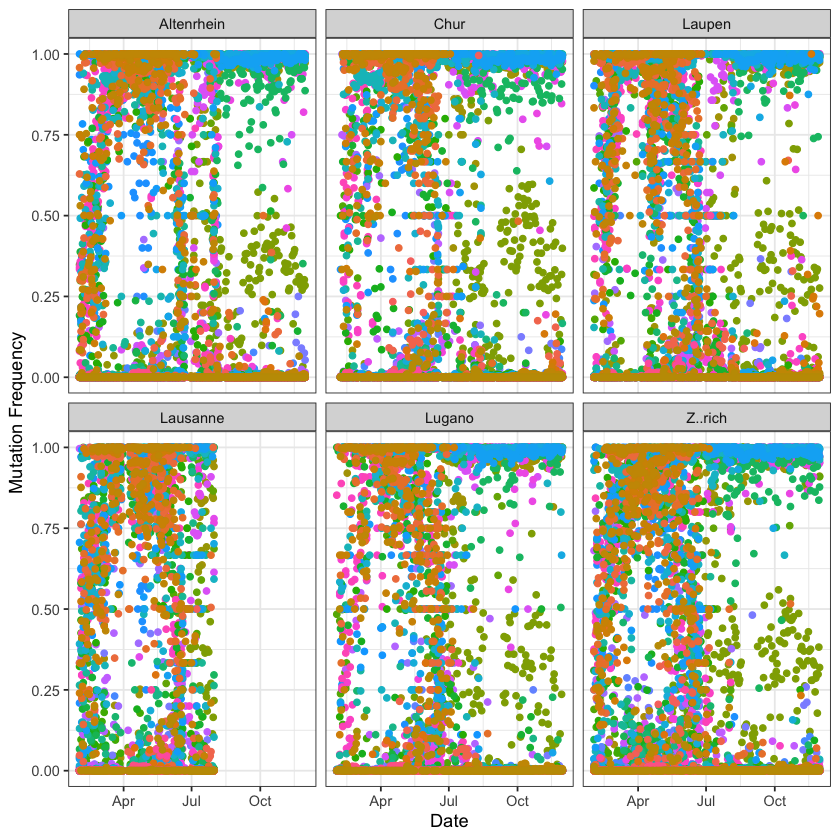

In [3]:
ggplot(jahn) +
    aes(x = ymd(date), y = frequency, colour = mutation) +
    geom_point() +
    facet_wrap(~ locality) +
    theme(legend.position = "none") +
    labs(x = "Date", y = "Mutation Frequency")


In [4]:
head(jahn)


,X,mutation,sample,date,locality,count,coverage,frequency,var_B.1.1.7,var_B.1.351,var_B.1.617.2,var_P.1
,<int>,<chr>,<chr>,<date>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,1,aa:E:P71L,ERR5922198,2021-02-13,Lausanne,1,3018,0.0003313453,0,1,0,0
2,2,aa:E:P71L,ERR5922199,2021-02-12,Lausanne,1,1177,0.0008496177,0,1,0,0
3,3,aa:E:P71L,ERR5922200,2021-02-10,Lausanne,2,4726,0.0004231909,0,1,0,0
4,4,aa:E:P71L,ERR5922201,2021-02-09,Lausanne,2,4032,0.0004960317,0,1,0,0
5,5,aa:E:P71L,ERR5922202,2021-02-07,Lausanne,1,4953,0.0002018978,0,1,0,0
6,6,aa:E:P71L,ERR5922203,2021-02-06,Lausanne,0,11,0.0000000000,0,1,0,0


In [5]:
jahn$dane <- as.numeric(ymd(jahn[, "date"]))
j2 <- jahn[jahn$locality == "Lugano", ]
j2 <- jahn %>%
    filter(locality == "Lugano") %>%
    rename(alpha = var_B.1.1.7, delta = var_B.1.617.2, 
        gamma = var_P.1, beta = var_B.1.351)


# Varying Coefficient Models

The general form of the models is:
$$
y_{i_t,t} = \beta_{0,t} + \beta_{1,t}x_{i_t,1,t} + ... + \epsilon_{i_t, t}
$$
where $\beta_{\cdot,t}$ represents the coefficient at time $t$.

Notice that there's no restriction that the values have the same indexing across all time points. At time point $t = 1$, we may have that $i_1$ goes from 1 to $n_1$, and at time point 2 $i_2=1...n_2$, etc. This is the reason for the excessive subscripting.

As can be seen in the other notebooks in this repository, it is possible to find $\beta_{\cdot, t}$ completely separately for each time point. That is, we can just fit a different model at each time point $t$. This separates this work from much of the other work labelled "Time-Varying Coefficients Models"; in TVC models, there are often too few observations (often just one) at each time point, but the coefficients are estimated at every time point. This is possible because we can share information across time points by assuming a smooth structure. 

This work also seeks a smooth structure on the coefficients, which means we must balance the information from the data at time $t$ with the information surrounding it. An interesting feature of this approach is that the covariates do not change over time - a particular mutation is always in the same lineage. In practice, we ignore the mutation label and just work with the frequency (or count/coverage), but it's worth noting for potential extensions.

In this code, I explore some possible ways to model this structure.


# Unconstrained Coefficients

In this basic model, we're just modelling each time point separately

In [6]:
head(j2)


,X,mutation,sample,date,locality,count,coverage,frequency,alpha,beta,delta,gamma,dane
,<int>,<chr>,<chr>,<date>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,21,aa:E:P71L,ERR9861200,2021-11-24,Lugano,0,19,0,0,1,0,0,18955
2,22,aa:E:P71L,ERR9861201,2021-11-25,Lugano,0,3,0,0,1,0,0,18956
3,23,aa:E:P71L,ERR9861202,2021-11-26,Lugano,0,2,0,0,1,0,0,18957
4,24,aa:E:P71L,ERR9861203,2021-11-27,Lugano,0,838,0,0,1,0,0,18958
5,25,aa:E:P71L,ERR9861204,2021-11-28,Lugano,0,7,0,0,1,0,0,18959
6,26,aa:E:P71L,ERR9861205,2021-11-29,Lugano,0,16,0,0,1,0,0,18960


In [7]:
samples <- unique(j2$sample)
suppressWarnings(
    ests <- sapply(samples, function(x) {
        glm(
            formula = cbind(count, coverage - count) ~ -1 + 
                alpha + beta + gamma + delta,
            family = binomial(link = logit),
            data = j2[j2$sample == x,]
        ) |> coef() |> expit()
    }) |> t()
)
colnames(ests) <- paste0("est_", colnames(ests))
ests <- as.data.frame(ests)
ests$sample <- rownames(ests)
j2_dates <- data.frame(date = j2[, "date"], sample = j2[, "sample"]) %>%
    distinct()
ests <- left_join(ests, j2_dates, by = "sample")
lests <- tidyr::pivot_longer(ests, -c(date, sample))


sample,date,name,value
<chr>,<date>,<chr>,<dbl>
ERR9861200,2021-11-24,est_alpha,5.971270e-04
ERR9861200,2021-11-24,est_beta,5.841070e-04
ERR9861200,2021-11-24,est_gamma,8.129314e-06
ERR9861200,2021-11-24,est_delta,4.428927e-03
ERR9861201,2021-11-25,est_alpha,8.220298e-04
ERR9861201,2021-11-25,est_beta,5.032072e-04


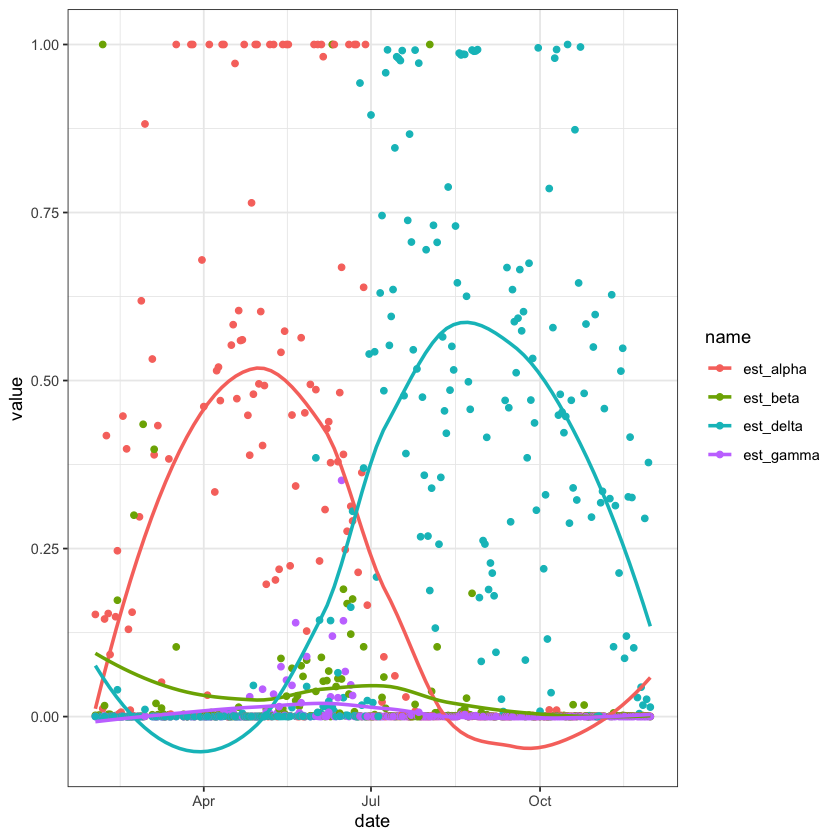

In [8]:
head(lests)
ggplot(lests) + 
    aes(x = date, y = value, colour = name) +
    geom_point() +
    geom_smooth(method = "loess", formula = y ~ x, se = FALSE)


As we can see, Alpha took off early, then around May-June we saw Beta and Gamma try to spread, but Delta took over everything. Delta made it to about 50% according to the mutation definitions that we are using. 

This is what we'll look for in VCM models - we want to characterize this trend.

# Generalized Additive Models

GAMs allow for a `by` argument, which according to the help page for the `s()` function is exactly what we are looking for in the equation above. A formula of the form `y ~ x + s(t, by = z)` will fit a regression of the form:
$$
y_i = \beta_0 + \beta_1x_i + s(t_i)z_i
$$
where $s(t_i)$ is a smooth function of time, evaluated at the observed time points. 

Notice that the coefficients in the equation from before can be written as:
$$
y_{i_t,t} = \beta_{0}(t) + \beta_{1}(t)x_{i_t,1,t} + ... + \epsilon_{i_t, t}
$$
That is, the $\beta$ terms are actually just arbitrary functions of time - exactly what we see in the GAM!

For our purposes, we don't want an interecept term. We have a set of lineages Alpha, Beta, Gamma, and Delta, which are just binary covariates indicating the presence of a mutation in a lineage. This makes our equation:
$$
f_{i_t, t} = \beta_\alpha(t) * Alpha + \beta_\beta(t)*Beta + \beta_\gamma(t)*Gamma + \beta_\delta(t)*Delta
$$
and yes, it feels really weird writing $\beta_\beta(t)*Beta$ and I kinda love it.

As a side note, the `by()` function changes its behaviour depending on whether the `by` variable is a factor. Suppose $z$ is either 0 or 1, then `gam(y ~ s(x, by = factor(z)))` results in the model:
$$
y_i = s(x) + s(x)I_{z_i = 0}
$$
That is, it creates replicates of the smooth, which is not what we want (this can be useful if there are a lot of categories with meaningful values that have interactions with other smooths). 


## Applying this craziness

Let's start simply to see why this works. The smooth terms are simply smooths over time. In essence, we have something like:

,X,mutation,sample,date,locality,count,coverage,frequency,alpha,beta,delta,gamma,dane
,<int>,<chr>,<chr>,<date>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,2255,aa:M:I82T,ERR9862288,2021-02-03,Lugano,0,8,0.0000000000,0,0,1,0,18661
2,2256,aa:M:I82T,ERR9862290,2021-02-05,Lugano,1,2324,0.0004302926,0,0,1,0,18663
3,2257,aa:M:I82T,ERR9862291,2021-02-06,Lugano,0,1117,0.0000000000,0,0,1,0,18664
4,2258,aa:M:I82T,ERR9862292,2021-02-07,Lugano,33,84611,0.0003900202,0,0,1,0,18665
5,2259,aa:M:I82T,ERR9862293,2021-02-08,Lugano,26,72362,0.0003593046,0,0,1,0,18666
6,2260,aa:M:I82T,ERR9862294,2021-02-09,Lugano,3,22277,0.0001346680,0,0,1,0,18667


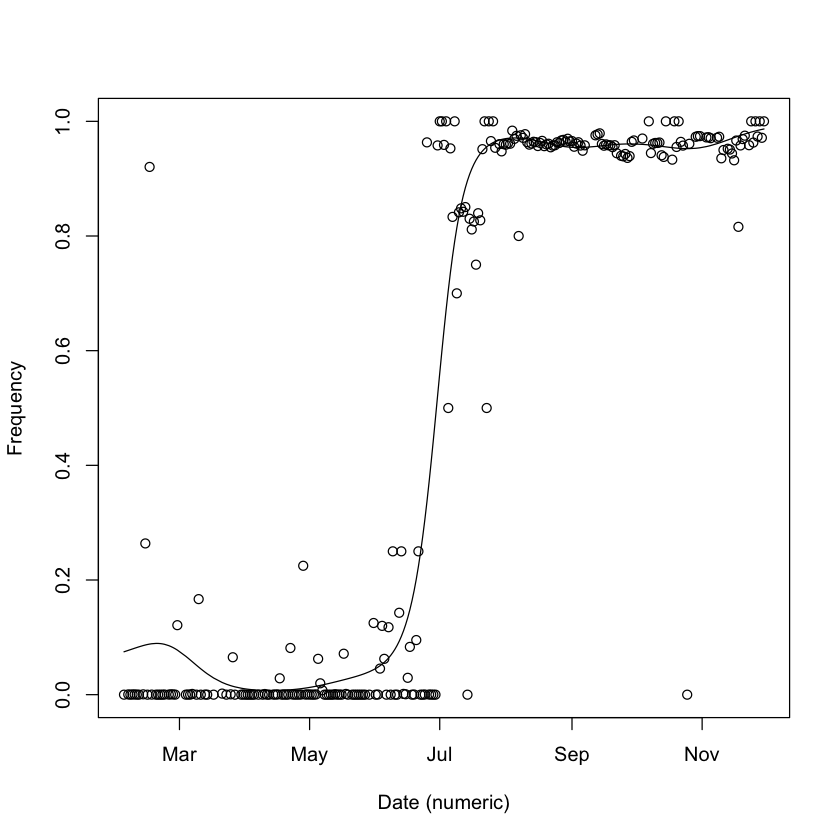

In [9]:
one_mut_df = j2[j2$mutation == unique(j2$mutation)[2], ]
one_mut_df <- arrange(one_mut_df, dane)
head(one_mut_df)

one_mutation <- gam(
    formula = cbind(count, coverage - count) ~ -1 + s(dane),
    data = one_mut_df,
    family = binomial(link = logit)
)

plot(x = one_mut_df$date, 
    y = predict(one_mutation, type = "response"), 
    type = "l", ylim = c(0, 1),
    xlab = "Date (numeric)", ylab = "Frequency")
points(frequency ~ date, data = one_mut_df)


The plot above is for a single mutation.

,X,mutation,sample,date,locality,count,coverage,frequency,alpha,beta,delta,gamma,dane
,<int>,<chr>,<chr>,<date>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,5299,aa:N:D3L,ERR9862286,2021-02-01,Lugano,0,3465,0.000000000,1,0,0,0,18659
2,11448,aa:N:S235F,ERR9862286,2021-02-01,Lugano,15,31,0.483870968,1,0,0,0,18659
3,21601,aa:orf1a:T1001I,ERR9862286,2021-02-01,Lugano,0,217,0.000000000,1,0,0,0,18659
4,32841,aa:orf8:Q27*,ERR9862286,2021-02-01,Lugano,1,601,0.001663894,1,0,0,0,18659
5,34358,aa:orf8:R52I,ERR9862286,2021-02-01,Lugano,2,598,0.003344482,1,0,0,0,18659
6,35882,aa:orf8:Y73C,ERR9862286,2021-02-01,Lugano,3473,4075,0.852269939,1,0,0,0,18659


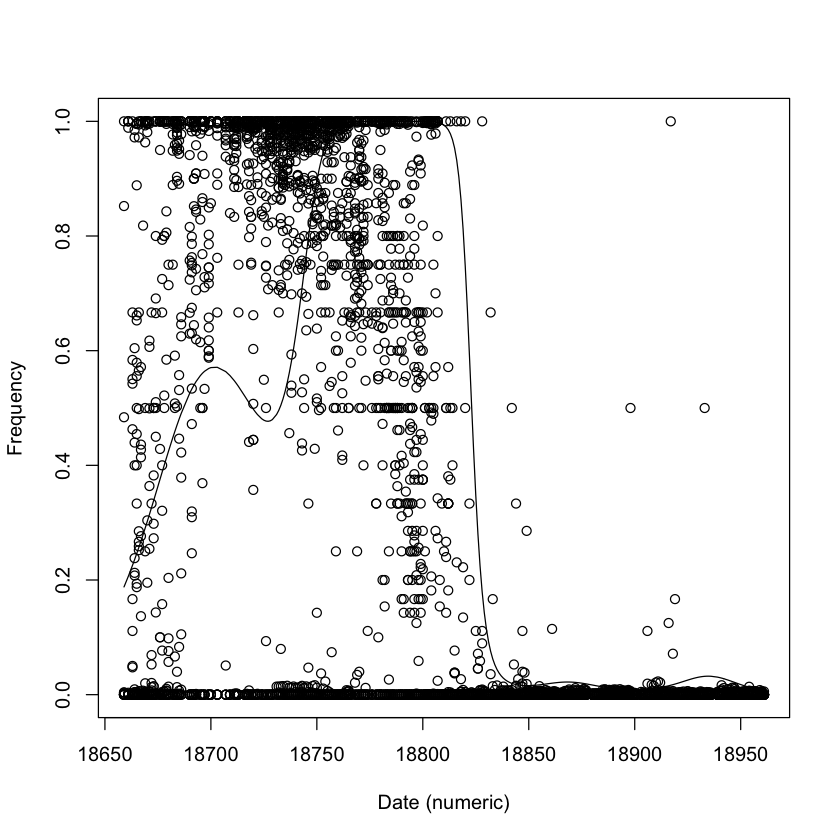

In [10]:
one_var_df <- j2[j2$alpha == 1, ]
one_var_df <- arrange(one_var_df, dane)
head(one_var_df)

one_variant <- gam(
    formula = cbind(count, coverage - count) ~ -1 + s(dane),
    data = one_var_df,
    family = binomial(link = logit)
)

plot(x = sort(unique(one_var_df$dane)), 
    y = predict(one_variant, newdata = list(dane = sort(unique(one_var_df$dane))), type = "response"), 
    type = "l", ylim = c(0, 1),
    xlab = "Date (numeric)", ylab = "Frequency")
points(frequency ~ dane, data = one_var_df)


The plot above is the spline term fit to all mutations in the Alpha variant.

To fit the TVC for lineage proportion estimation, the spline terms are estimated such that they attempt to predict all of the mutations that are part of the variant definition, while accounting for shared mutations. This is what is done below.

In [11]:
mygam <- gam(
    formula = cbind(count, coverage - count) ~ -1 +
        s(dane, by = alpha, bs = "cs") +
        s(dane, by = beta, bs = "cs") +
        s(dane, by = gamma, bs = "cs") +
        s(dane, by = delta, bs = "cs"),
    data = j2,
    family = binomial(link = logit),
    select = TRUE
)


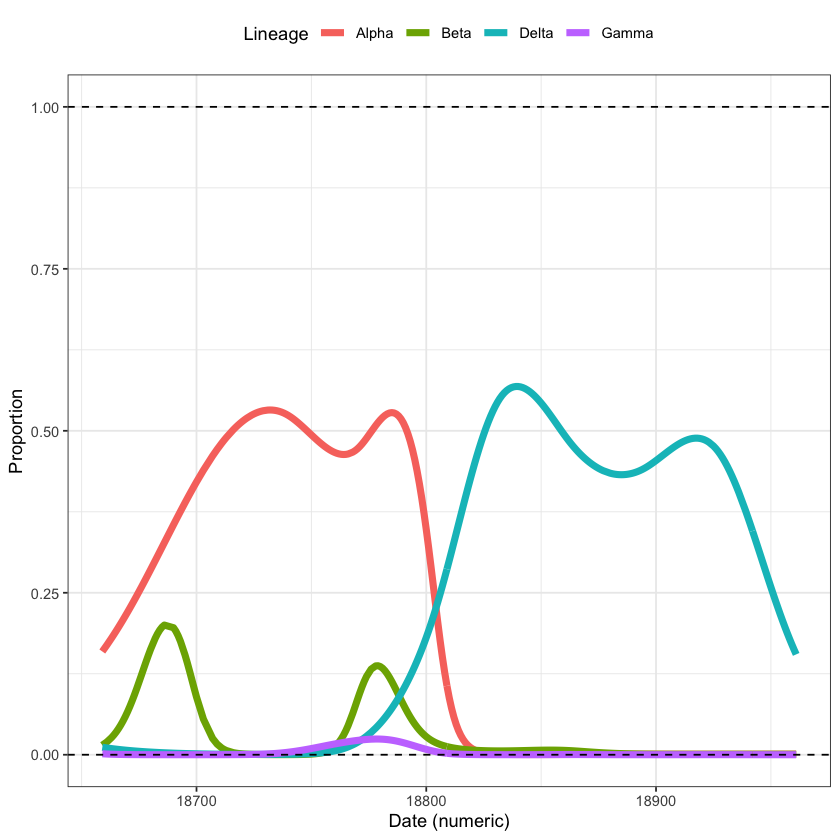

In [12]:
danes <- sort(unique(j2$dane))
smooths <- bind_rows(
    data.frame(dane = danes, s = "Alpha",
        alpha = 1, beta = 0, gamma = 0, delta = 0),
    data.frame(dane = danes, s = "Beta",
        alpha = 0, beta = 1, gamma = 0, delta = 0),
    data.frame(dane = danes, s = "Gamma",
        alpha = 0, beta = 0, gamma = 1, delta = 0),
    data.frame(dane = danes, s = "Delta",
        alpha = 0, beta = 0, gamma = 0, delta = 1),
)
smooths$pred = predict(mygam, smooths, type = "response")
ggplot(smooths) +
    aes(x = dane, y = pred, colour = s) +
    geom_line(linewidth = 2) +
    coord_cartesian(ylim = c(0, 1)) +
    labs(x = "Date (numeric)", y = "Proportion",
        colour = "Lineage") +
    geom_hline(yintercept = c(0, 1), linetype = "dashed") +
    theme(legend.position = "top")


What we expected to see was Alpha, followed by small bumps of Beta and Gamma, then a surge in Delta. This is more or less what we got! (Note: in a previous version I erroneously included an intercept term which lead to poor results. It's the magic of knowing what regression you want to fit.)

I have played around with different bases (`bs` argument), including Gaussian Processes, thin plate splines, cubic regression splines, B-splines, and P-splines, but all provide pretty much identical results. For now, I'm sticking with cubic regression splines with shrinkage to allow some terms to be shrunk to 0, as this method includes selection and 

In [13]:
summary(mygam)



Family: binomial 
Link function: logit 

Formula:
cbind(count, coverage - count) ~ -1 + s(dane, by = alpha, bs = "cs") + 
    s(dane, by = beta, bs = "cs") + s(dane, by = gamma, bs = "cs") + 
    s(dane, by = delta, bs = "cs")

Approximate significance of smooth terms:
                edf Ref.df   Chi.sq p-value    
s(dane):alpha 9.974     10 10778281  <2e-16 ***
s(dane):beta  9.975     10  3662405  <2e-16 ***
s(dane):gamma 9.988     10  3991221  <2e-16 ***
s(dane):delta 9.944     10  7477403  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =   0.52   Deviance explained = 65.6%
UBRE = 9364.8  Scale est. = 1         n = 12885